<a href="https://colab.research.google.com/github/HJJunn/sentence_order/blob/main/%EB%AC%B8%EC%9E%A5_%EC%88%9C%EC%84%9C_T5_epoch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
from transformers import TFT5ForConditionalGeneration, T5TokenizerFast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1) 데이터 확인

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

ID            0
sentence_0    0
sentence_1    0
sentence_2    0
sentence_3    0
answer_0      0
answer_1      0
answer_2      0
answer_3      0
dtype: int64
ID            0
sentence_0    0
sentence_1    0
sentence_2    0
sentence_3    0
dtype: int64


In [ ]:
print("학습 데이터 개수:",len(train))
print("테스트 데이터 개수:", len(test))

학습 데이터 개수: 7351
테스트 데이터 개수: 1780


# 2) 데이터 전처리



1.   sentence, answer끼리 하나로 합치기
2.   sentence: 입력, answer = 레이블
3.   입력 앞에 prefix 추가 : "문장을 순서대로 정렬하세요: "
4.   문장 구분점 < /s > 삽입
5.   입력 정수 인코딩
6.   target 레이블을 문자열 형태로 변경 -> "2 0 1 3"


In [ ]:
# 입력 텍스트와 타겟 텍스트를 구성하는 함수
def make_input(row):
    sentences = [row[f"sentence_{i}"] for i in range(4)]
    input_text = "문장을 순서대로 정렬하세요: " + " </s> ".join(sentences)
    answer = [row[f"answer_{i}"] for i in range(4)]
    target_text = " ".join(map(str, answer))  # 예: "0 3 1 2"
    return {"input": input_text, "target": target_text}

In [ ]:
inputs = train.apply(make_input, axis=1).tolist()
train_data, valid_data = train_test_split(inputs, test_size=0.2, random_state=42)

샘플의 최대 길이: 304
샘플의 최소 길이: 92


(array([2.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 3.100e+01, 9.200e+01,
        2.760e+02, 4.720e+02, 8.730e+02, 1.027e+03, 1.265e+03, 1.135e+03,
        8.190e+02, 6.210e+02, 3.340e+02, 2.060e+02, 1.260e+02, 4.000e+01,
        1.500e+01, 6.000e+00]),
 array([ 92. , 102.6, 113.2, 123.8, 134.4, 145. , 155.6, 166.2, 176.8,
        187.4, 198. , 208.6, 219.2, 229.8, 240.4, 251. , 261.6, 272.2,
        282.8, 293.4, 304. ]),
 <BarContainer object of 20 artists>)

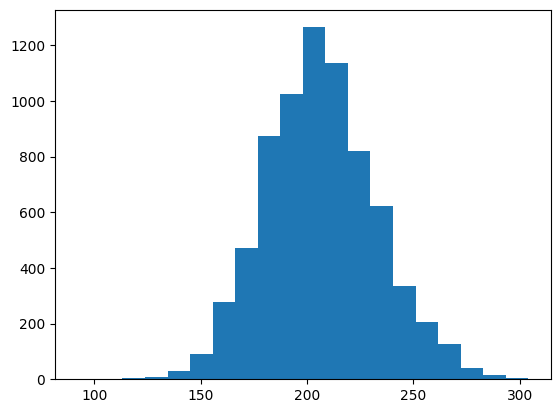

In [ ]:
from matplotlib import pyplot as plt
print("샘플의 최대 길이: %d" % max(len(i['input']) for i in inputs))
print("샘플의 최소 길이: %d" % min(len(i['input']) for i in inputs))
plt.hist([len(i['input']) for i in inputs], bins=20)

In [ ]:
print(len(train_data))
print(len(valid_data))

5880
1471


In [ ]:
class T5ReorderDataset(tf.keras.utils.Sequence):
    def __init__(self, data, tokenizer, input_max_len, target_max_len, batch_size, ignore_index=-100):
        self.tokenizer = tokenizer
        self.input_max_len = input_max_len
        self.target_max_len = target_max_len
        self.data = data
        self.batch_size = batch_size
        self.ignore_index = ignore_index
        self.indices = list(range(len(self.data)))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        if start_idx >= len(self.indices):
            raise IndexError(f"Invalid batch index: {idx}, start_idx {start_idx} >= {len(self.indices)}")
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch = [self.data[i] for i in batch_indices]

        input_ids = []
        labels = []

        for example in batch:
            encoded_input = self.tokenizer.encode(
                example["input"],
                max_length=self.input_max_len,
                padding='max_length',
                truncation=True
            )
            encoded_target = self.tokenizer.encode(
                example["target"],
                max_length=self.target_max_len,
                padding='max_length',
                truncation=True
            )

            label = [token if token != self.tokenizer.pad_token_id else self.ignore_index
                     for token in encoded_target]

            input_ids.append(encoded_input)
            labels.append(label)

        return {
            'input_ids': np.array(input_ids, dtype=np.int32),
            'labels': np.array(labels, dtype=np.int32)
        }

    def on_epoch_end(self):
        np.random.shuffle(self.indices)



# 3) 모델 클래스 선언

In [ ]:
model = TFT5ForConditionalGeneration.from_pretrained('paust/pko-t5-base' , from_pt = True)
tokenizer = T5TokenizerFast.from_pretrained('paust/pko-t5-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model T

# 4) 데이터 로더 변환

In [ ]:

lr = 3e-5
max_epochs = 7
warmup_ratio = 0.1

In [ ]:
train_dataset = T5ReorderDataset(train_data, tokenizer, 256, 16, batch_size=8)
valid_dataset = T5ReorderDataset(valid_data, tokenizer, 256, 16, batch_size=8)



total_steps = len(train_dataset) * max_epochs
warmup_steps = int(total_steps * warmup_ratio)
lr_schedule = CosineDecay(initial_learning_rate = lr, decay_steps = total_steps)
optimizer = Adam(learning_rate = lr_schedule)

# 5) 데이터 확인

In [ ]:
print("첫번째 샘플의 원문 텍스트:", train_data[0]['input'])

첫번째 샘플의 원문 텍스트: 문장을 순서대로 정렬하세요: 시민들이 의사 결정 과정에 참여함으로써, 정책의 신뢰성과 수용성이 증대된다. </s> 원자력 발전소의 안전성과 환경적 영향을 고려할 때, 효과적인 위험 거버넌스가 필수적이다. </s> 결국, 원자력 위험 거버넌스는 시민과의 협력을 통해 더욱 강화될 수 있다. </s> 이 과정에서 시민 참여는 투명성을 높이고, 지역 사회의 우려를 반영하는 중요한 역할을 한다.


In [ ]:
print("정수 인코딩 및 패딩 결과:", train_dataset[0]['input_ids'][0])
print("텍스트 길이:", len(train_dataset[0]['input_ids'][0]))

정수 인코딩 및 패딩 결과: [ 4321   291   222  4652   927   222 18817   963    27   222  2076  3708
   222  2183   222  1530   222  1405   279   222  1466   584  3101    13
   222  1769   302   222  3080  3339   222  5326 14613   222  9578   883
    15   222     1   222  7765   589   222  1852   402   302   222   968
  3339   222  1409   403   222  2075   291   222  2409   411   222   483
    13   222  1440 34939   222  2399   222 31547   278   222 24446   570
    15   222     1   222  1783    13   222  7765   589   222  2399   222
 31547   274   222  2076  2526   222  2338   291   222   948   222  1546
   222  1856   764   222   334   222   530    15   222     1   222   262
   222  1405   389   222  2076   222  1466   274   222  3835   396   291
   222  8917    13   222   828   222  1191   302   222  2835   333   222
  3167   429   222  1317   305   222  2312   291   222   588    15     1
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     

In [ ]:
print("첫번째 샘플의 정수 인코딩 후 복원 결과:", tokenizer.decode(train_dataset[0]['input_ids'][0]))

첫번째 샘플의 정수 인코딩 후 복원 결과: 문장을 순서대로 정렬하세요: 시민들이 의사 결정 과정에 참여함으로써, 정책의 신뢰성과 수용성이 증대된다. </s> 원자력 발전소의 안전성과 환경적 영향을 고려할 때, 효과적인 위험 거버넌스가 필수적이다. </s> 결국, 원자력 위험 거버넌스는 시민과의 협력을 통해 더욱 강화될 수 있다. </s> 이 과정에서 시민 참여는 투명성을 높이고, 지역 사회의 우려를 반영하는 중요한 역할을 한다.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
print("첫번째 샘플의 레이블:" , train_data[0]['target'])

첫번째 샘플의 레이블: 1 3 0 2


In [ ]:
print("ID 222의 토큰:", tokenizer.convert_ids_to_tokens(222))


ID 222의 토큰: Ġ


In [ ]:
print("첫번째 샘플의 레이블의 정수 인코딩 및 패딩 결과:", train_dataset[0]['labels'][0])

첫번째 샘플의 레이블의 정수 인코딩 및 패딩 결과: [  18  222   20  222   17  222   19    1 -100 -100 -100 -100 -100 -100
 -100 -100]


In [ ]:
test_array = train_dataset[0]['labels'][0]
test_array[test_array == -100] = 0

print("첫번째 샘플의 레이블:", tokenizer.decode(test_array))

첫번째 샘플의 레이블: 1 3 0 2</s><pad><pad><pad><pad><pad><pad><pad><pad>


# 6) 어텐션 마스크 함수

In [ ]:
def create_attention_mask(input_ids):
    input_ids = tf.convert_to_tensor(input_ids)
    boolean_mask = tf.not_equal(input_ids, tokenizer.pad_token_id)
    return tf.cast(boolean_mask, tf.float32)

# 7) 학습

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/t5_reorder_model'

In [ ]:
from transformers import TFT5ForConditionalGeneration

# 1. 저장된 모델 불러오기
save_path = "/content/drive/MyDrive/Colab Notebooks/t5_reorder_model"
model = TFT5ForConditionalGeneration.from_pretrained(save_path)

# 2. 이어서 학습
best_loss = 0.1052
start_epoch = 5
max_epochs = 7

for epoch in range(start_epoch, max_epochs):
    print(f'에포크 {epoch+1}/ {max_epochs}')

    total_train_loss = 0.0
    for batch in tqdm(train_dataset, total=len(train_dataset), desc='훈련중'):
        attention_mask = create_attention_mask(batch['input_ids'])
        with tf.GradientTape() as tape:
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=attention_mask,
                            labels=batch['labels'],
                            training=True)
            loss = tf.cast(outputs.loss, tf.float32)

        total_train_loss += tf.reduce_mean(loss).numpy()
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    avg_train_loss = total_train_loss / len(train_dataset)
    print(f'훈련 손실 : {avg_train_loss: .4f}')

    # 검증
    total_val_loss = 0.0
    for batch in tqdm(valid_dataset, total=len(valid_dataset), desc='검증 중'):
        attention_mask = create_attention_mask(batch['input_ids'])
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=attention_mask,
                        labels=batch['labels'],
                        training=False)
        total_val_loss += tf.reduce_mean(outputs.loss).numpy()

    avg_val_loss = total_val_loss / len(valid_dataset)
    print(f"검증 손실 :  {avg_val_loss: .4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        model.save_pretrained(save_path)
        print(f"검증 손실이 {best_loss: .4f}로 개선")

    train_dataset.on_epoch_end()

print("훈련이 완료되었습니다.")


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/t5_reorder_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


에포크 6/ 7


훈련중: 100%|██████████| 735/735 [33:24<00:00,  2.73s/it]


훈련 손실 :  0.0961


검증 중: 184it [01:37,  1.89it/s]


검증 손실 :   0.1000
검증 손실이  0.1000로 개선
에포크 7/ 7


훈련중: 100%|██████████| 735/735 [32:44<00:00,  2.67s/it]


훈련 손실 :  0.0767


검증 중: 184it [01:35,  1.93it/s]

검증 손실 :   0.1004
훈련이 완료되었습니다.


# 8) 추론

In [ ]:
# 테스트 데이터
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
sentences = test[[f"sentence_{i}" for i in range(4)]].values.tolist()

In [ ]:
from tqdm import tqdm

def reorder_batch(sent_batch, tokenizer, model, batch_size=16):
    predictions = []
    for i in tqdm(range(0, len(sent_batch), batch_size), desc="Predicting batches"):
        batch = sent_batch[i:i + batch_size]

        input_texts = ["문장을 순서대로 정렬하세요: " + " </s> ".join(sents) for sents in batch]

        inputs = tokenizer(
            input_texts,
            return_tensors="tf",
            padding="max_length",
            truncation=True,
            max_length=256
        )

        attention_mask = tf.cast(tf.not_equal(inputs['input_ids'], tokenizer.pad_token_id), tf.float32)

        reorder_ids = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=attention_mask,
            max_length=16,
            num_beams=1
        )

        decoded_batch = tokenizer.batch_decode(reorder_ids, skip_special_tokens=True)

        for decoded in decoded_batch:
            try:
                order = list(map(int, decoded.strip().split()))
                predictions.append(order)
            except:
                predictions.append([0, 1, 2, 3])  # fallback 예측
    return predictions

predictions = reorder_batch(sentences, tokenizer, model, batch_size=16)


Predicting batches: 100%|██████████| 112/112 [05:00<00:00,  2.68s/it]


In [ ]:
# true_orders는 문장 리스트 (기존)
true_orders = test[[f"sentence_{i}" for i in range(4)]].values.tolist()

# predictions가 인덱스 리스트이니, 예측 문장 리스트로 변환
predicted_sentences = []
for pred_idx_list, sentences in zip(predictions, true_orders):
    ordered_sentences = [sentences[i] for i in pred_idx_list]
    predicted_sentences.append(ordered_sentences)

# 이제 predicted_sentences와 true_orders 비교
exact_matches = sum([pred == true for pred, true in zip(predicted_sentences, true_orders)])
exact_accuracy = exact_matches / len(predictions)

# 부분 정확도
partial_accuracies = []
for pred, true in zip(predicted_sentences, true_orders):
    correct_positions = sum([p == t for p, t in zip(pred, true)])
    partial_accuracies.append(correct_positions / len(pred))

average_partial_accuracy = np.mean(partial_accuracies)

print("전체 정확도 (Exact Match Accuracy):", round(exact_accuracy, 4))
print("부분 정확도 평균 (Average Position Accuracy):", round(average_partial_accuracy, 4))
print("총 샘플 수:", len(predictions))


전체 정확도 (Exact Match Accuracy): 0.0365
부분 정확도 평균 (Average Position Accuracy): 0.2576
총 샘플 수: 1780


In [ ]:
for i in range(5):  # 앞 5개 샘플만 출력
    print(f"샘플 {i+1}")
    print("원문 문장들:")
    for idx, sent in enumerate(true_orders[i]):
        print(f"  문장 {idx}: {sent}")
    print("모델 예측 순서 인덱스:", predictions[i])
    print("모델이 예측한 문장 순서:")
    for j, pred_idx in enumerate(predictions[i]):
        print(f"  위치 {j}: {true_orders[i][pred_idx]}")
    print("정답 문장 순서:")
    for j, sent in enumerate(true_orders[i]):
        print(f"  위치 {j}: {sent}")
    print("-" * 50)


샘플 1
원문 문장들:
  문장 0: 자유 의지와 결정론은 서로 상충하는 개념으로 여겨지지만, 이 둘의 공존 가능성도 탐구할 가치가 있다.
  문장 1: 결정론은 모든 사건이 원인과 결과의 연쇄에 의해 발생한다고 주장하며, 이는 인간의 행동에도 적용될 수 있다.
  문장 2: 그러나 인간의 인식과 선택 과정에서 나타나는 복잡성과 예측 불가능성은 자유 의지의 존재를 시사한다.
  문장 3: 결국, 자유 의지와 결정론은 서로를 배제하기보다는, 인간 경험의 다양한 측면을 설명하는 데 기여할 수 있는 상호 보완적인 개념으로 이해될 수 있다.
모델 예측 순서 인덱스: [0, 1, 2, 3]
모델이 예측한 문장 순서:
  위치 0: 자유 의지와 결정론은 서로 상충하는 개념으로 여겨지지만, 이 둘의 공존 가능성도 탐구할 가치가 있다.
  위치 1: 결정론은 모든 사건이 원인과 결과의 연쇄에 의해 발생한다고 주장하며, 이는 인간의 행동에도 적용될 수 있다.
  위치 2: 그러나 인간의 인식과 선택 과정에서 나타나는 복잡성과 예측 불가능성은 자유 의지의 존재를 시사한다.
  위치 3: 결국, 자유 의지와 결정론은 서로를 배제하기보다는, 인간 경험의 다양한 측면을 설명하는 데 기여할 수 있는 상호 보완적인 개념으로 이해될 수 있다.
정답 문장 순서:
  위치 0: 자유 의지와 결정론은 서로 상충하는 개념으로 여겨지지만, 이 둘의 공존 가능성도 탐구할 가치가 있다.
  위치 1: 결정론은 모든 사건이 원인과 결과의 연쇄에 의해 발생한다고 주장하며, 이는 인간의 행동에도 적용될 수 있다.
  위치 2: 그러나 인간의 인식과 선택 과정에서 나타나는 복잡성과 예측 불가능성은 자유 의지의 존재를 시사한다.
  위치 3: 결국, 자유 의지와 결정론은 서로를 배제하기보다는, 인간 경험의 다양한 측면을 설명하는 데 기여할 수 있는 상호 보완적인 개념으로 이해될 수 있다.
--------------------------------------------------
샘플 2
원문 문장들:
  문장

In [ ]:
# sample_submission 불러오기
sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample_submission.csv")

# 예측 결과 적용
for i in range(4):
    sample_submission[f"answer_{i}"] = [
        pred[i] if len(pred) == 4 else i for pred in predictions
    ]

# 저장 경로 설정
save_path = "/content/drive/MyDrive/Colab Notebooks/문맥 기반 문장 순서 예측_T5.csv"

# 저장
sample_submission.to_csv(save_path, index=False)
